# Generating a box plot for the distribution of the tumor cell population and fraction

## Import libraries

In [1]:
# %matplotlib notebook
#  add Python-loader repo to the path 
import sys
sys.path.insert(0, '../Python-loader/')
from pyMCDS import pyMCDS

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as sts
from scipy.integrate import odeint
from scipy.ndimage.filters import gaussian_filter

## Define cell cycle model

In [13]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 6

output_folder = "output_Experimental_Settings_R300/"

## Define experimental settings

In [14]:
num_folders = 18
num_params = 3

settings = np.zeros((num_folders, num_params))
settings[0,:] = np.array([6, 100, 10])
settings[1,:] = np.array([6, 100, 20])
settings[2,:] = np.array([6, 100, 50])
settings[3,:] = np.array([6, 100, 100])
settings[4,:] = np.array([6, 100, 200])
settings[5,:] = np.array([6, 100, 300])
settings[6,:] = np.array([6, 500, 10])
settings[7,:] = np.array([6, 500, 20])
settings[8,:] = np.array([6, 500, 50])
settings[9,:] = np.array([6, 500, 100])
settings[10,:] = np.array([6, 500, 200])
settings[11,:] = np.array([6, 500, 300])
settings[12,:] = np.array([6, 1000, 10])
settings[13,:] = np.array([6, 1000, 20])
settings[14,:] = np.array([6, 1000, 50])
settings[15,:] = np.array([6, 1000, 100])
settings[16,:] = np.array([6, 1000, 200])
settings[17,:] = np.array([6, 1000, 300])

## Compute the number of each tumor cell phenotype over all replicates and simulation times

In [15]:
def get_folder_name(settings):
    if cycle_model == 0:
        folder_name = "output_Ki67_Advanced_"
    elif cycle_model == 1:
        folder_name = "output_Ki67_Basic_"
    elif cycle_model == 2:
        folder_name = "output_Flow_Cytometry_"
    elif cycle_model == 5:
        folder_name = "output_Live_"
    elif cycle_model == 6:
        folder_name = "output_Separated_Flow_Cytometry_"
    else:
        print("Unrecognized cell cycle model.")
    
    if settings[0].is_integer():
        folder_name += "dt" + str(int(settings[0])) + "_NC" + str(int(settings[1])) + "_R" + str(int(settings[2])) + "/"
    else:
        folder_name += "dt" + str(settings[0]) + "_NC" + str(int(settings[1])) + "_R" + str(int(settings[2])) + "/"
    
    return folder_name

In [16]:
last_index = 120;
filename = "PhysiCell_tumor_cell_population.csv";

times = [None] * num_folders; 
if cycle_model == 0:
    Ki67_negative_count = [None] * num_folders; 
    Ki67_positive_premitotic_count = [None] * num_folders; 
    Ki67_positive_postmitotic_count = [None] * num_folders; 
elif cycle_model == 1:
    Ki67_negative_count = [None] * num_folders; 
    Ki67_positive_count = [None] * num_folders; 
elif cycle_model == 2:
    G0G1_phase_count = [None] * num_folders; 
    S_phase_count = [None] * num_folders; 
    G2M_phase_count = [None] * num_folders; 
elif cycle_model == 5:
    live_count = [None] * num_folders; 
elif cycle_model == 6:
    G0G1_phase_count = [None] * num_folders; 
    S_phase_count = [None] * num_folders; 
    G2_phase_count = [None] * num_folders; 
    M_phase_count = [None] * num_folders; 
else:
    print("Unrecognized cell cycle model.")
dead_count = [None] * num_folders; 

for i in range(num_folders):
    num_replicates = int(settings[i,2])
    
    times[i] = np.zeros( last_index+1 ); 
    if cycle_model == 0:
        Ki67_negative_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_premitotic_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_postmitotic_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 1:
        Ki67_negative_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 2:
        G0G1_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2M_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 5:
        live_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 6:
        G0G1_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        M_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        print("Unrecognized cell cycle model.")
    dead_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    
    for id_replicate in range(num_replicates):
        folder_name = output_folder+get_folder_name(settings[i,:])+"output_R"+str("%02d"%id_replicate)+'/'

        data = np.genfromtxt(folder_name + filename, dtype = float, delimiter = ',', names = True)
        times[i][:] = data["times"]
        if cycle_model == 0:
            Ki67_negative_count[i][id_replicate,:] = data["Ki67_negative_num"]
            Ki67_positive_premitotic_count[i][id_replicate,:] = data["Ki67_positive_premitotic_num"]
            Ki67_positive_postmitotic_count[i][id_replicate,:] = data["Ki67_positive_postmitotic_num"]
        elif cycle_model == 1:
            Ki67_negative_count[i][id_replicate,:] = data["Ki67_negative_num"]
            Ki67_positive_count[i][id_replicate,:] = data["Ki67_positive_num"]
        elif cycle_model == 2:
            G0G1_phase_count[i][id_replicate,:] = data["G0G1_phase_num"]
            S_phase_count[i][id_replicate,:] = data["S_phase_premitotic_num"]
            G2M_phase_count[i][id_replicate,:] = data["G2M_phase_postmitotic_num"]
        elif cycle_model == 5:
            live_count[i][id_replicate,:] = data["Live_num"]
        elif cycle_model == 6:
            G0G1_phase_count[i][id_replicate,:] = data["G0G1_phase_num"]
            S_phase_count[i][id_replicate,:] = data["S_phase_premitotic_num"]
            G2_phase_count[i][id_replicate,:] = data["G2_phase_postmitotic_num"]
            M_phase_count[i][id_replicate,:] = data["M_phase_postmitotic_num"]
        else:
            print("Unrecognized cell cycle model.")
        dead_count[i][id_replicate,:] = data["Dead_num"]

## Compute tumor cell fraction over all replicates and simulation times

In [17]:
has_apop_nec = False

if cycle_model == 0:
    Ki67_negative_fraction = [None] * num_folders; 
    Ki67_positive_premitotic_fraction = [None] * num_folders; 
    Ki67_positive_postmitotic_fraction = [None] * num_folders; 
elif cycle_model == 1:
    Ki67_negative_fraction = [None] * num_folders; 
    Ki67_positive_fraction = [None] * num_folders; 
elif cycle_model == 2:
    G0G1_phase_fraction = [None] * num_folders; 
    S_phase_fraction = [None] * num_folders; 
    G2M_phase_fraction = [None] * num_folders; 
elif cycle_model == 5:
    live_fraction = [None] * num_folders; 
elif cycle_model == 6:
    G0G1_phase_fraction = [None] * num_folders; 
    S_phase_fraction = [None] * num_folders; 
    G2_phase_fraction = [None] * num_folders; 
    M_phase_fraction = [None] * num_folders; 
else:
    print("Unrecognized cell cycle model.")

if has_apop_nec:
    apoptotic_fraction = [None] * num_folders; 
    necrotic_fraction = [None] * num_folders; 
else:
    dead_fraction = [None] * num_folders; 
    
for i in range(num_folders):
    num_replicates = int(settings[i,2])
    
    if cycle_model == 0:
        Ki67_negative_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_premitotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_postmitotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 1:
        Ki67_negative_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 2:
        G0G1_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2M_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 5:
        live_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 6:
        G0G1_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        M_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        print("Unrecognized cell cycle model.")

    if has_apop_nec:
        apoptotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        necrotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        dead_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        
    for id_replicate in range(num_replicates):
        if cycle_model == 0:
            total_count = Ki67_negative_count[i][id_replicate,:] + Ki67_positive_premitotic_count[i][id_replicate,:] + Ki67_positive_postmitotic_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            Ki67_negative_fraction[i][id_replicate,:] = Ki67_negative_count[i][id_replicate,:]/total_count;
            Ki67_positive_premitotic_fraction[i][id_replicate,:] = Ki67_positive_premitotic_count[i][id_replicate,:]/total_count;
            Ki67_positive_postmitotic_fraction[i][id_replicate,:] = Ki67_positive_postmitotic_count[i][id_replicate,:]/total_count;
        elif cycle_model == 1:
            total_count = Ki67_negative_count[i][id_replicate,:] + Ki67_positive_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            Ki67_negative_fraction[i][id_replicate,:] = Ki67_negative_count[i][id_replicate,:]/total_count;
            Ki67_positive_fraction[i][id_replicate,:] = Ki67_positive_count[i][id_replicate,:]/total_count;
        elif cycle_model == 2:
            total_count = G0G1_phase_count[i][id_replicate,:] + S_phase_count[i][id_replicate,:] + G2M_phase_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            G0G1_phase_fraction[i][id_replicate,:] = G0G1_phase_count[i][id_replicate,:]/total_count;
            S_phase_fraction[i][id_replicate,:] = S_phase_count[i][id_replicate,:]/total_count;
            G2M_phase_fraction[i][id_replicate,:] = G2M_phase_count[i][id_replicate,:]/total_count;
        elif cycle_model == 5:
            total_count = live_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            live_fraction[i][id_replicate,:] = live_count[i][id_replicate,:]/total_count;
        elif cycle_model == 6:
            total_count = G0G1_phase_count[i][id_replicate,:] + S_phase_count[i][id_replicate,:] + G2_phase_count[i][id_replicate,:] + M_phase_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            G0G1_phase_fraction[i][id_replicate,:] = G0G1_phase_count[i][id_replicate,:]/total_count;
            S_phase_fraction[i][id_replicate,:] = S_phase_count[i][id_replicate,:]/total_count;
            G2_phase_fraction[i][id_replicate,:] = G2_phase_count[i][id_replicate,:]/total_count;
            M_phase_fraction[i][id_replicate,:] = M_phase_count[i][id_replicate,:]/total_count;
        else:
            print("Unrecognized cell cycle model.")

        if has_apop_nec:
            apoptotic_fraction[i][id_replicate,:] = apoptotic_count[i][id_replicate,:]/total_count;
            necrotic_fraction[i][id_replicate,:] = necrotic_count[i][id_replicate,:]/total_count;
        else:
            dead_fraction[i][id_replicate,:] = dead_count[i][id_replicate,:]/total_count;

## Solve true model numerically

In [18]:
true_solution = [None] * num_folders

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post,
            r01*Ki67_neg - r12*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post
        ]
        return dXdt
    
    r01 = 0.004604052
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    r01 = 0.003631082
    r10 = 0.001075269
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    b = 0.0007198228
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
else:
    print("Unrecognized cell cycle model.")
    
for i in range(num_folders):
    number_of_cells = int(settings[i,1])
    
    if cycle_model == 0:
        X0 = np.array([number_of_cells, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r10, r12, r20))
    elif cycle_model == 1:
        X0 = np.array([number_of_cells, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r10))
    elif cycle_model == 2:
        X0 = np.array([number_of_cells, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r20, r12))
    elif cycle_model == 5:
        X0 = np.array([number_of_cells])
        true_solution[i] = odeint(true_model, X0, times[i], args=(b,))
    elif cycle_model == 6:
        X0 = np.array([number_of_cells, 0, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r30, r12, r23))
    else:
        print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [19]:
if cycle_model == 0:
    Ki67_negative_true = [None] * num_folders;
    Ki67_positive_premitotic_true = [None] * num_folders;
    Ki67_positive_postmitotic_true = [None] * num_folders;
elif cycle_model == 1:
    Ki67_negative_true = [None] * num_folders;
    Ki67_positive_true = [None] * num_folders;
elif cycle_model == 2:
    G0G1_phase_true = [None] * num_folders;
    S_phase_true = [None] * num_folders;
    G2M_phase_true = [None] * num_folders;
elif cycle_model == 5:
    live_true = [None] * num_folders;
elif cycle_model == 6:
    G0G1_phase_true = [None] * num_folders;
    S_phase_true = [None] * num_folders;
    G2_phase_true = [None] * num_folders;
    M_phase_true = [None] * num_folders;
else:
    print("Unrecognized cell cycle model.")
    
for i in range(num_folders):
    total_true = np.sum(true_solution[i], axis=1)

    if cycle_model == 0:
        Ki67_negative_true[i] = true_solution[i][:,0]/total_true;
        Ki67_positive_premitotic_true[i] = true_solution[i][:,1]/total_true;
        Ki67_positive_postmitotic_true[i] = true_solution[i][:,2]/total_true;
    elif cycle_model == 1:
        Ki67_negative_true[i] = true_solution[i][:,0]/total_true;
        Ki67_positive_true[i] = true_solution[i][:,1]/total_true;
    elif cycle_model == 2:
        G0G1_phase_true[i] = true_solution[i][:,0]/total_true;
        S_phase_true[i] = true_solution[i][:,1]/total_true;
        G2M_phase_true[i] = true_solution[i][:,2]/total_true;
    elif cycle_model == 5:
        live_true[i] = true_solution[i][:,0]/total_true;
    elif cycle_model == 6:
        G0G1_phase_true[i] = true_solution[i][:,0]/total_true;
        S_phase_true[i] = true_solution[i][:,1]/total_true;
        G2_phase_true[i] = true_solution[i][:,2]/total_true;
        M_phase_true[i] = true_solution[i][:,3]/total_true;
    else:
        print("Unrecognized cell cycle model.")

## Generate a box plot for the distribution of the tumor cell population at the final simulation time

In [20]:
def plot_whisker(data, true, xticks, cell_cycle_phase_title, xlabel, cell_cycle_phase_filename):
    colors = ['tab:red', 'tab:green', 'tab:blue']
    
    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    bp = plt.boxplot(data, patch_artist=False, sym="k.", showmeans=True, meanline=True)
    hline = plt.axhline(true, label = "True", color='tab:red', linestyle=':')
    plt.legend([bp['medians'][0], bp['means'][0], hline], ["Median", "Mean", "True"], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(np.arange(1, len(data)+1), xticks)
    
    # plt.title( 'Box plot for the distribution of the ' + cell_cycle_phase_title, size=20)
    plt.xlabel( xlabel, size=15 )
    plt.ylabel( cell_cycle_phase_title, size=15 )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + ".pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

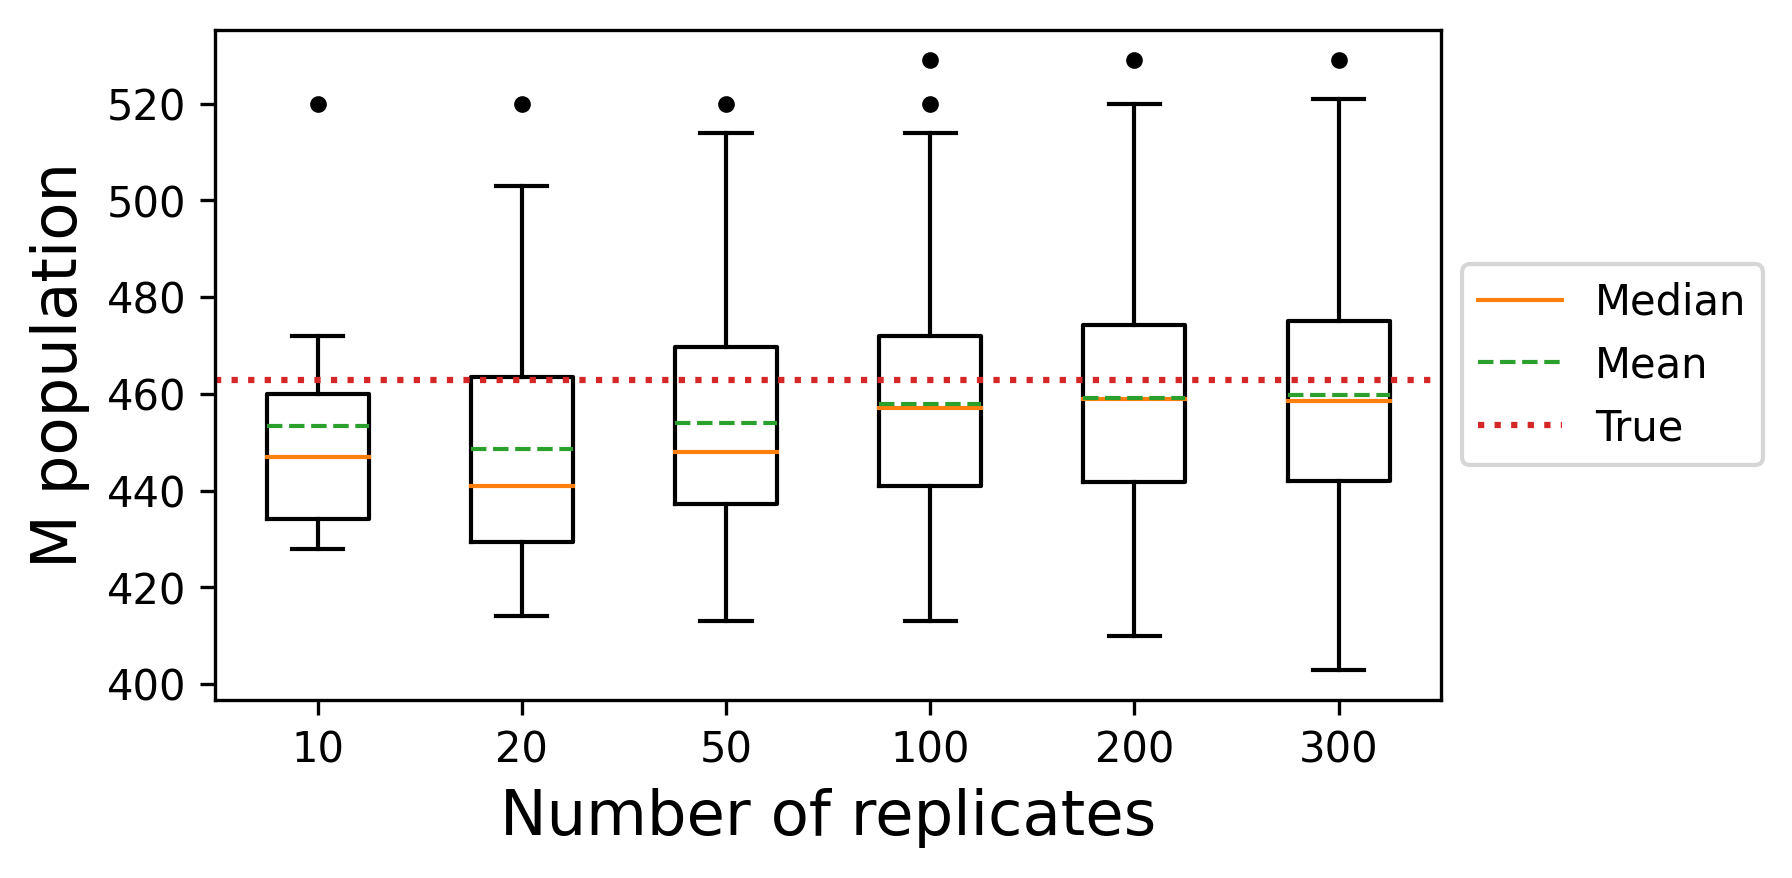

In [21]:
NC100_indices = np.where(settings[:,1] == 100)[0]
NC500_indices = np.where(settings[:,1] == 500)[0]
NC1000_indices = np.where(settings[:,1] == 1000)[0]

if cycle_model == 0:
    data = [Ki67_negative_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,0], settings[NC100_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC100")
    data = [Ki67_negative_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,0], settings[NC500_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC500")
    data = [Ki67_negative_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,0], settings[NC1000_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC1000")
    
    data = [Ki67_positive_premitotic_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,1], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ (pre) population", "Number of replicates", "Ki67_pos_pre_pop_whisker_NC100")
    data = [Ki67_positive_premitotic_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,1], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ (pre) population", "Number of replicates", "Ki67_pos_pre_pop_whisker_NC500")
    data = [Ki67_positive_premitotic_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,1], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ (pre) population", "Number of replicates", "Ki67_pos_pre_pop_whisker_NC1000")
    
    data = [Ki67_positive_postmitotic_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,2], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ (post) population", "Number of replicates", "Ki67_pos_post_pop_whisker_NC100")
    data = [Ki67_positive_postmitotic_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,2], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ (post) population", "Number of replicates", "Ki67_pos_post_pop_whisker_NC500")
    data = [Ki67_positive_postmitotic_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,2], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ (post) population", "Number of replicates", "Ki67_pos_post_pop_whisker_NC1000")
elif cycle_model == 1:
    data = [Ki67_negative_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,0], settings[NC100_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC100")
    data = [Ki67_negative_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,0], settings[NC500_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC500")
    data = [Ki67_negative_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,0], settings[NC1000_indices,2].astype(int), r"Ki67$^{-}$ population", "Number of replicates", "Ki67_neg_pop_whisker_NC1000")
    
    data = [Ki67_positive_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,1], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ population", "Number of replicates", "Ki67_pos_pop_whisker_NC100")
    data = [Ki67_positive_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,1], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ population", "Number of replicates", "Ki67_pos_pop_whisker_NC500")
    data = [Ki67_positive_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,1], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ population", "Number of replicates", "Ki67_pos_pop_whisker_NC1000")
elif cycle_model == 2:
    data = [G0G1_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,0], settings[NC100_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC100")
    data = [G0G1_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,0], settings[NC500_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC500")
    data = [G0G1_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,0], settings[NC1000_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC1000")
    
    data = [S_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,1], settings[NC100_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC100")
    data = [S_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,1], settings[NC500_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC500")
    data = [S_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,1], settings[NC1000_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC1000")
    
    data = [G2M_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,2], settings[NC100_indices,2].astype(int), r"G2/M population", "Number of replicates", "G2M_phase_pop_whisker_NC100")
    data = [G2M_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,2], settings[NC500_indices,2].astype(int), r"G2/M population", "Number of replicates", "G2M_phase_pop_whisker_NC500")
    data = [G2M_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,2], settings[NC1000_indices,2].astype(int), r"G2/M population", "Number of replicates", "G2M_phase_pop_whisker_NC1000")
elif cycle_model == 5:
    data = [live_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,0], settings[NC100_indices,2].astype(int), r"Live population", "Number of replicates", "Live_pop_whisker_NC100")
    data = [live_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,0], settings[NC500_indices,2].astype(int), r"Live population", "Number of replicates", "Live_pop_whisker_NC500")
    data = [live_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,0], settings[NC1000_indices,2].astype(int), r"Live population", "Number of replicates", "Live_pop_whisker_NC1000")
elif cycle_model == 6:
    data = [G0G1_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,0], settings[NC100_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC100")
    data = [G0G1_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,0], settings[NC500_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC500")
    data = [G0G1_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,0], settings[NC1000_indices,2].astype(int), r"G0/G1 population", "Number of replicates", "G0G1_phase_pop_whisker_NC1000")
    
    data = [S_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,1], settings[NC100_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC100")
    data = [S_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,1], settings[NC500_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC500")
    data = [S_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,1], settings[NC1000_indices,2].astype(int), r"S population", "Number of replicates", "S_phase_pop_whisker_NC1000")
    
    data = [G2_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,2], settings[NC100_indices,2].astype(int), r"G2 population", "Number of replicates", "G2_phase_pop_whisker_NC100")
    data = [G2_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,2], settings[NC500_indices,2].astype(int), r"G2 population", "Number of replicates", "G2_phase_pop_whisker_NC500")
    data = [G2_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,2], settings[NC1000_indices,2].astype(int), r"G2 population", "Number of replicates", "G2_phase_pop_whisker_NC1000")
    
    data = [M_phase_count[i][:,-1] for i in NC100_indices]
    plot_whisker(data, true_solution[NC100_indices[0]][-1,3], settings[NC100_indices,2].astype(int), r"M population", "Number of replicates", "M_phase_pop_whisker_NC100")
    data = [M_phase_count[i][:,-1] for i in NC500_indices]
    plot_whisker(data, true_solution[NC500_indices[0]][-1,3], settings[NC500_indices,2].astype(int), r"M population", "Number of replicates", "M_phase_pop_whisker_NC500")
    data = [M_phase_count[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, true_solution[NC1000_indices[0]][-1,3], settings[NC1000_indices,2].astype(int), r"M population", "Number of replicates", "M_phase_pop_whisker_NC1000")
else:
    print("Unrecognized cell cycle model.")

## Generate a box plot for the distribution of the tumor cell fraction at the final simulation time

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

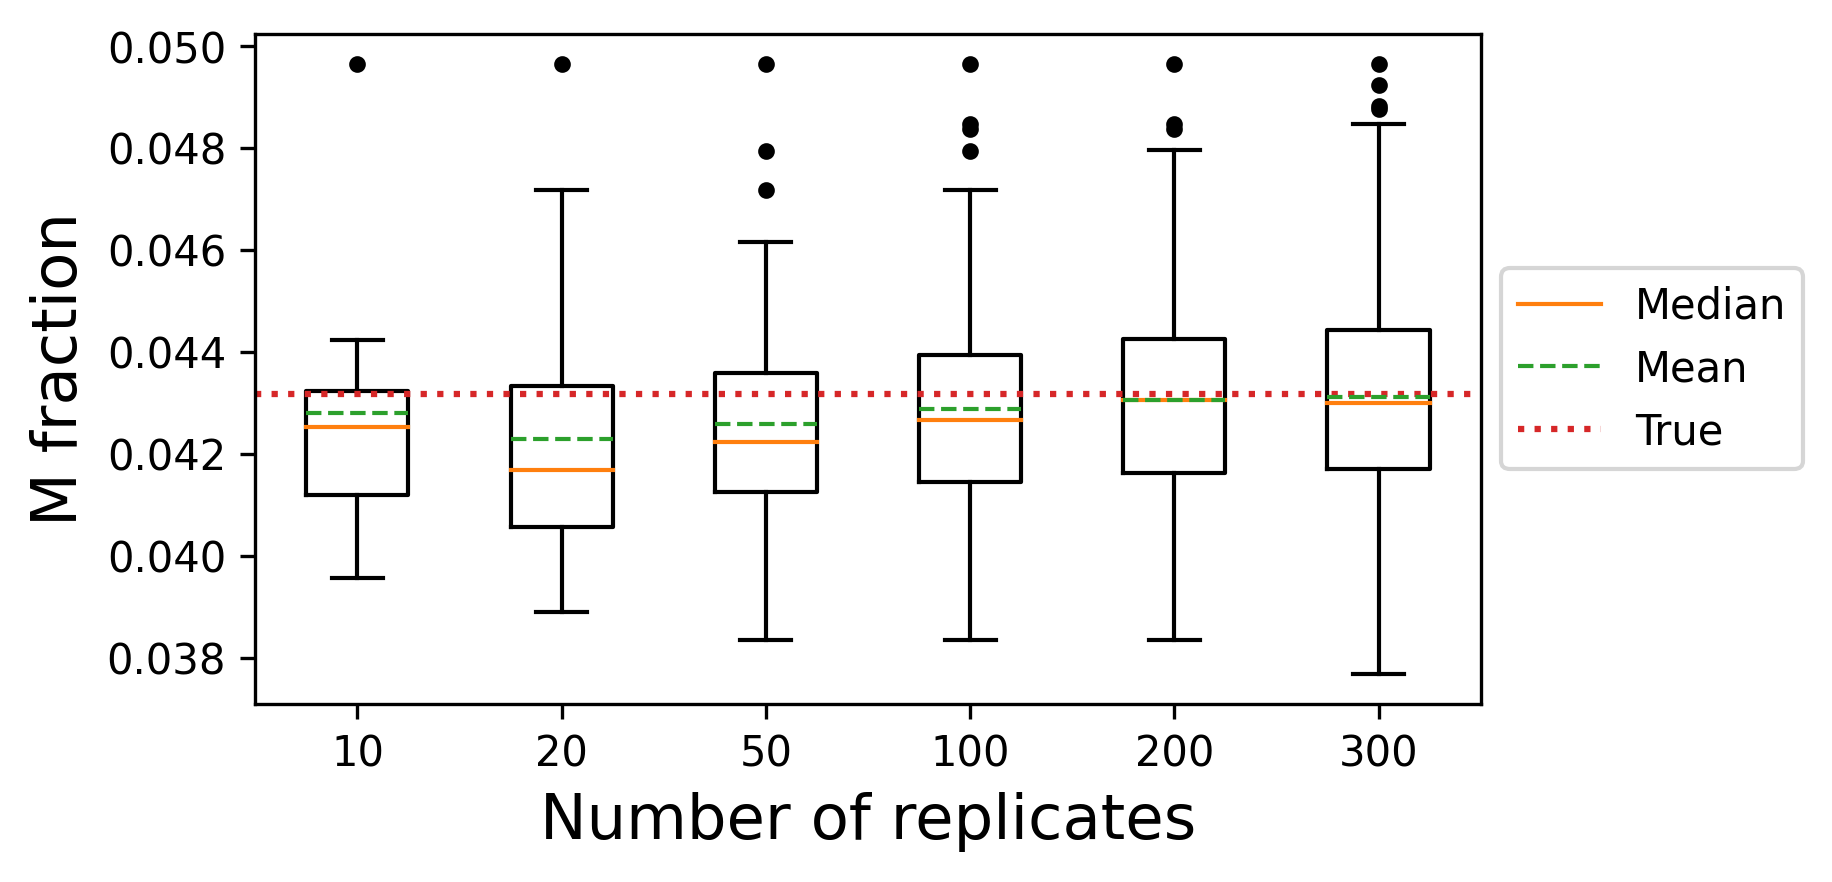

In [22]:
if cycle_model == 0:
    data = [Ki67_negative_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, Ki67_negative_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC100")
    data = [Ki67_negative_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, Ki67_negative_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC500")
    data = [Ki67_negative_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, Ki67_negative_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC1000")
    
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ (pre) fraction", "Number of replicates", "Ki67_pos_pre_frac_whisker_NC100")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ (pre) fraction", "Number of replicates", "Ki67_pos_pre_frac_whisker_NC500")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ (pre) fraction", "Number of replicates", "Ki67_pos_pre_frac_whisker_NC1000")
    
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ (post) fraction", "Number of replicates", "Ki67_pos_post_frac_whisker_NC100")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ (post) fraction", "Number of replicates", "Ki67_pos_post_frac_whisker_NC500")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ (post) fraction", "Number of replicates", "Ki67_pos_post_frac_whisker_NC1000")
elif cycle_model == 1:
    data = [Ki67_negative_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, Ki67_negative_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC100")
    data = [Ki67_negative_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, Ki67_negative_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC500")
    data = [Ki67_negative_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, Ki67_negative_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Ki67$^{-}$ fraction", "Number of replicates", "Ki67_neg_frac_whisker_NC1000")
    
    data = [Ki67_positive_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, Ki67_positive_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Ki67$^{+}$ fraction", "Number of replicates", "Ki67_pos_frac_whisker_NC100")
    data = [Ki67_positive_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, Ki67_positive_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Ki67$^{+}$ fraction", "Number of replicates", "Ki67_pos_frac_whisker_NC500")
    data = [Ki67_positive_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, Ki67_positive_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Ki67$^{+}$ fraction", "Number of replicates", "Ki67_pos_frac_whisker_NC1000")
elif cycle_model == 2:
    data = [G0G1_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, G0G1_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC100")
    data = [G0G1_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, G0G1_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC500")
    data = [G0G1_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, G0G1_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC1000")
    
    data = [S_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, S_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC100")
    data = [S_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, S_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC500")
    data = [S_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, S_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC1000")
    
    data = [G2M_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, G2M_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"G2/M fraction", "Number of replicates", "G2M_phase_frac_whisker_NC100")
    data = [G2M_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, G2M_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"G2/M fraction", "Number of replicates", "G2M_phase_frac_whisker_NC500")
    data = [G2M_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, G2M_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"G2/M fraction", "Number of replicates", "G2M_phase_frac_whisker_NC1000")
elif cycle_model == 5:
    data = [live_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, live_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"Live fraction", "Number of replicates", "Live_frac_whisker_NC100")
    data = [live_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, live_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"Live fraction", "Number of replicates", "Live_frac_whisker_NC500")
    data = [live_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, live_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"Live fraction", "Number of replicates", "Live_frac_whisker_NC1000")
elif cycle_model == 6:
    data = [G0G1_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, G0G1_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC100")
    data = [G0G1_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, G0G1_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC500")
    data = [G0G1_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, G0G1_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"G0/G1 fraction", "Number of replicates", "G0G1_phase_frac_whisker_NC1000")
    
    data = [S_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, S_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC100")
    data = [S_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, S_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC500")
    data = [S_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, S_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"S fraction", "Number of replicates", "S_phase_frac_whisker_NC1000")
    
    data = [G2_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, G2_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"G2 fraction", "Number of replicates", "G2_phase_frac_whisker_NC100")
    data = [G2_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, G2_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"G2 fraction", "Number of replicates", "G2_phase_frac_whisker_NC500")
    data = [G2_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, G2_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"G2 fraction", "Number of replicates", "G2_phase_frac_whisker_NC1000")
    
    data = [M_phase_fraction[i][:,-1] for i in NC100_indices]
    plot_whisker(data, M_phase_true[NC100_indices[0]][-1], settings[NC100_indices,2].astype(int), r"M fraction", "Number of replicates", "M_phase_frac_whisker_NC100")
    data = [M_phase_fraction[i][:,-1] for i in NC500_indices]
    plot_whisker(data, M_phase_true[NC500_indices[0]][-1], settings[NC500_indices,2].astype(int), r"M fraction", "Number of replicates", "M_phase_frac_whisker_NC500")
    data = [M_phase_fraction[i][:,-1] for i in NC1000_indices]
    plot_whisker(data, M_phase_true[NC1000_indices[0]][-1], settings[NC1000_indices,2].astype(int), r"M fraction", "Number of replicates", "M_phase_frac_whisker_NC1000")
else:
    print("Unrecognized cell cycle model.")

## Generate a box plot for the distribution of the tumor cell fraction at the final simulation time

<ipython-input-20-d8c9a303569f>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)


<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

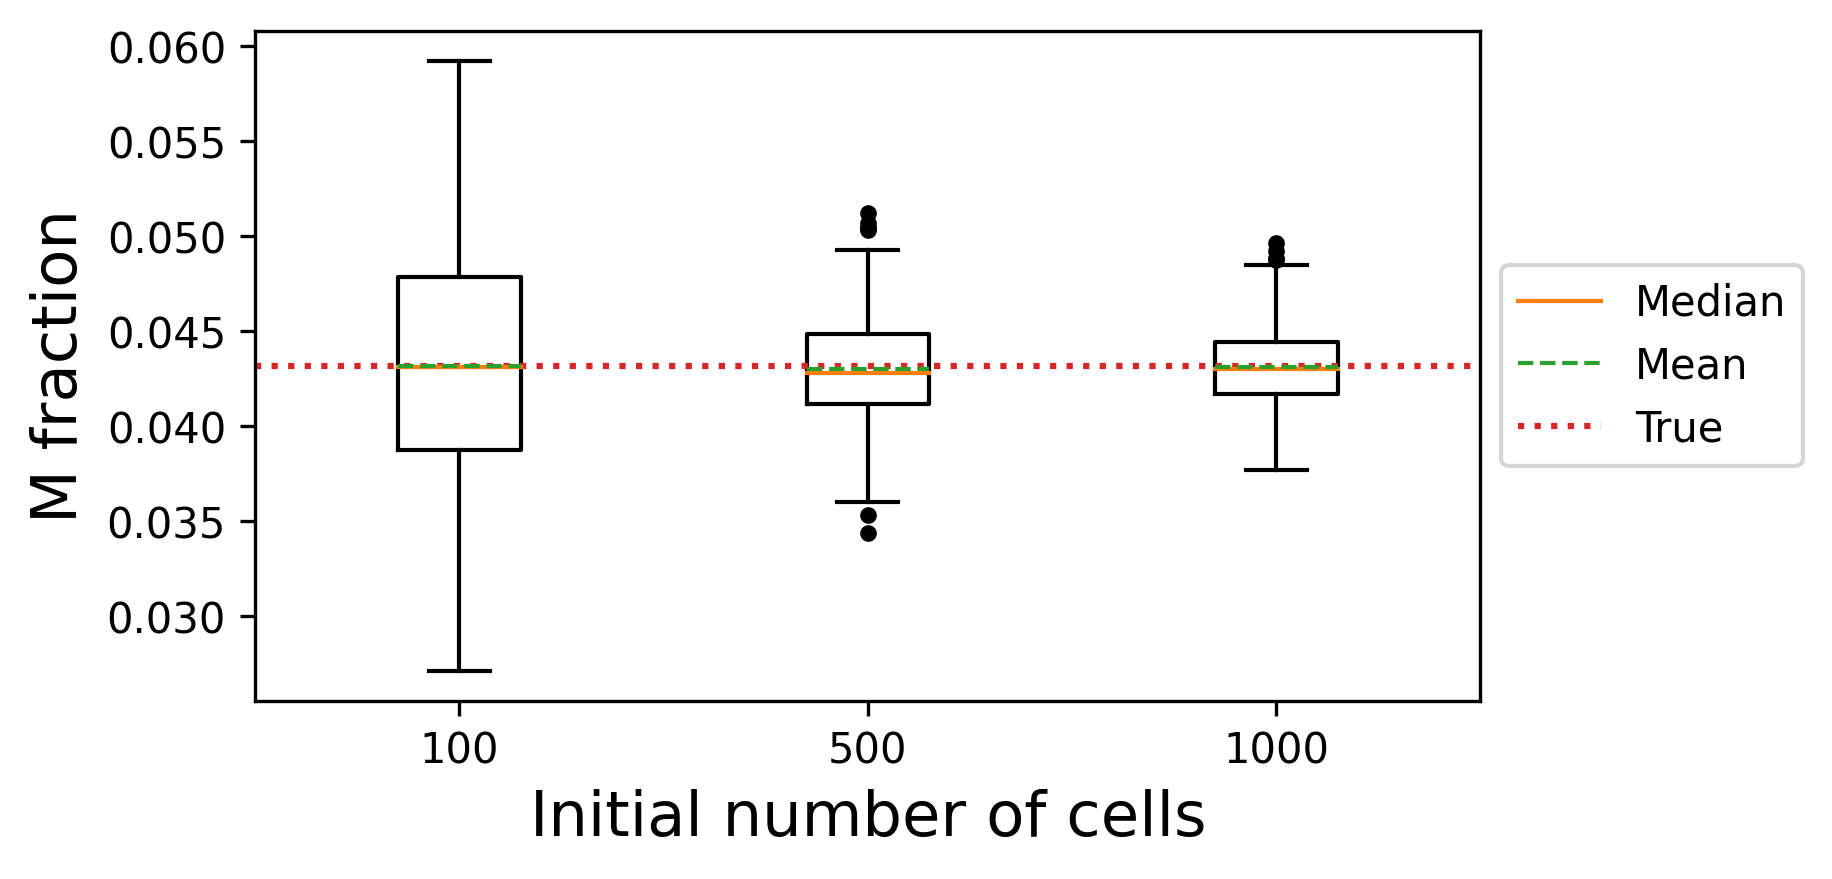

In [23]:
R10_indices = np.where(settings[:,2] == 10)[0]
R20_indices = np.where(settings[:,2] == 20)[0]
R50_indices = np.where(settings[:,2] == 50)[0]
R100_indices = np.where(settings[:,2] == 100)[0]
R200_indices = np.where(settings[:,2] == 200)[0]
R300_indices = np.where(settings[:,2] == 300)[0]

if cycle_model == 0:
    data = [Ki67_negative_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, Ki67_negative_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R10")
    data = [Ki67_negative_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, Ki67_negative_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R20")
    data = [Ki67_negative_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, Ki67_negative_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R50")
    data = [Ki67_negative_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, Ki67_negative_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R100")
    data = [Ki67_negative_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, Ki67_negative_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R200")
    data = [Ki67_negative_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, Ki67_negative_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R300")
    
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R10")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R20")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R50")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R100")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R200")
    data = [Ki67_positive_premitotic_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, Ki67_positive_premitotic_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Ki67$^{+}$ (pre) fraction", "Initial number of cells", "Ki67_pos_pre_frac_whisker_R300")
    
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R10")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R20")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R50")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R100")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R200")
    data = [Ki67_positive_postmitotic_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, Ki67_positive_postmitotic_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Ki67$^{+}$ (post) fraction", "Initial number of cells", "Ki67_pos_post_frac_whisker_R300")
elif cycle_model == 1:
    data = [Ki67_negative_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, Ki67_negative_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R10")
    data = [Ki67_negative_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, Ki67_negative_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R20")
    data = [Ki67_negative_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, Ki67_negative_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R50")
    data = [Ki67_negative_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, Ki67_negative_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R100")
    data = [Ki67_negative_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, Ki67_negative_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R200")
    data = [Ki67_negative_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, Ki67_negative_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Ki67$^{-}$ fraction", "Initial number of cells", "Ki67_neg_frac_whisker_R300")
    
    data = [Ki67_positive_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, Ki67_positive_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R10")
    data = [Ki67_positive_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, Ki67_positive_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R20")
    data = [Ki67_positive_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, Ki67_positive_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R50")
    data = [Ki67_positive_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, Ki67_positive_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R100")
    data = [Ki67_positive_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, Ki67_positive_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R200")
    data = [Ki67_positive_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, Ki67_positive_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Ki67$^{+}$ fraction", "Initial number of cells", "Ki67_pos_frac_whisker_R300")
elif cycle_model == 2:
    data = [G0G1_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, G0G1_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R10")
    data = [G0G1_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, G0G1_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R20")
    data = [G0G1_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, G0G1_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R50")
    data = [G0G1_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, G0G1_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R100")
    data = [G0G1_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, G0G1_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R200")
    data = [G0G1_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, G0G1_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R300")
    
    data = [S_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, S_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R10")
    data = [S_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, S_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R20")
    data = [S_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, S_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R50")
    data = [S_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, S_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R100")
    data = [S_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, S_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R200")
    data = [S_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, S_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R300")
    
    data = [G2M_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, G2M_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R10")
    data = [G2M_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, G2M_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R20")
    data = [G2M_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, G2M_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R50")
    data = [G2M_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, G2M_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R100")
    data = [G2M_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, G2M_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R200")
    data = [G2M_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, G2M_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"G2/M fraction", "Initial number of cells", "G2M_phase_frac_whisker_R300")
elif cycle_model == 5:
    data = [live_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, live_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R10")
    data = [live_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, live_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R20")
    data = [live_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, live_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R50")
    data = [live_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, live_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R100")
    data = [live_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, live_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R200")
    data = [live_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, live_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"Live fraction", "Initial number of cells", "Live_frac_whisker_R300")
elif cycle_model == 6:
    data = [G0G1_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, G0G1_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R10")
    data = [G0G1_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, G0G1_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R20")
    data = [G0G1_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, G0G1_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R50")
    data = [G0G1_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, G0G1_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R100")
    data = [G0G1_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, G0G1_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R200")
    data = [G0G1_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, G0G1_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"G0/G1 fraction", "Initial number of cells", "G0G1_phase_frac_whisker_R300")
    
    data = [S_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, S_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R10")
    data = [S_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, S_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R20")
    data = [S_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, S_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R50")
    data = [S_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, S_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R100")
    data = [S_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, S_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R200")
    data = [S_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, S_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"S fraction", "Initial number of cells", "S_phase_frac_whisker_R300")
    
    data = [G2_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, G2_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R10")
    data = [G2_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, G2_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R20")
    data = [G2_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, G2_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R50")
    data = [G2_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, G2_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R100")
    data = [G2_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, G2_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R200")
    data = [G2_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, G2_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"G2 fraction", "Initial number of cells", "G2_phase_frac_whisker_R300")
    
    data = [M_phase_fraction[i][:,-1] for i in R10_indices]
    plot_whisker(data, M_phase_true[R10_indices[-1]][-1], settings[R10_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R10")
    data = [M_phase_fraction[i][:,-1] for i in R20_indices]
    plot_whisker(data, M_phase_true[R20_indices[-1]][-1], settings[R20_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R20")
    data = [M_phase_fraction[i][:,-1] for i in R50_indices]
    plot_whisker(data, M_phase_true[R50_indices[-1]][-1], settings[R50_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R50")
    data = [M_phase_fraction[i][:,-1] for i in R100_indices]
    plot_whisker(data, M_phase_true[R100_indices[-1]][-1], settings[R100_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R100")
    data = [M_phase_fraction[i][:,-1] for i in R200_indices]
    plot_whisker(data, M_phase_true[R200_indices[-1]][-1], settings[R200_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R200")
    data = [M_phase_fraction[i][:,-1] for i in R300_indices]
    plot_whisker(data, M_phase_true[R300_indices[-1]][-1], settings[R300_indices,1].astype(int), r"M fraction", "Initial number of cells", "M_phase_frac_whisker_R300")
else:
    print("Unrecognized cell cycle model.")